# Chinook Business Analysis
Chinook is a record store that sells music of various genres. They have extensive database records and have requested some help extracting the useful information to shape their business decisions. 

In [26]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
%%sql
/* View all tables/views in db */
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

* sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


The Chinook record store has just signed a deal with a new record label, and wants to choose which three will slot into stores based on the success of the genre. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA based on the number of tracks sold.

In [28]:
 %%sql 
/* table of USA sales only */

CREATE VIEW USA_sales AS 
    SELECT 
        invoice_id,
        total
    FROM invoice
    WHERE billing_country = 'USA'



* sqlite:///chinook.db
(sqlite3.OperationalError) table USA_sales already exists
[SQL: /* table of USA sales only */

CREATE VIEW USA_sales AS 
   SELECT 
       invoice_id,
       total
   FROM invoice
   WHERE billing_country = 'USA']
(Background on this error at: http://sqlalche.me/e/e3q8)


In [29]:
%%sql top_usa_genres <<
/* Query db to find number of tracks sold in USA */
    SELECT
        g.name genre,
        COUNT(t.track_id) num_tracks_sold,
        ROUND(SUM(usa.total), 0) total_sales
    FROM USA_sales usa
    JOIN invoice_line il ON usa.invoice_id = il.invoice_id
    JOIN track t ON t.track_id = il.track_id
    JOIN genre g ON g.genre_id = t.genre_id 
    GROUP BY g.name

* sqlite:///chinook.db
Done.
Returning data to local variable top_usa_genres


In [30]:
# Re-format query into df
top_usa_genres = top_usa_genres.DataFrame()
top_usa_genres['pct_of_total'] = top_usa_genres['num_tracks_sold'] / top_usa_genres['num_tracks_sold'].sum() * 100
top_usa_genres = top_usa_genres.sort_values('pct_of_total', ascending=False)

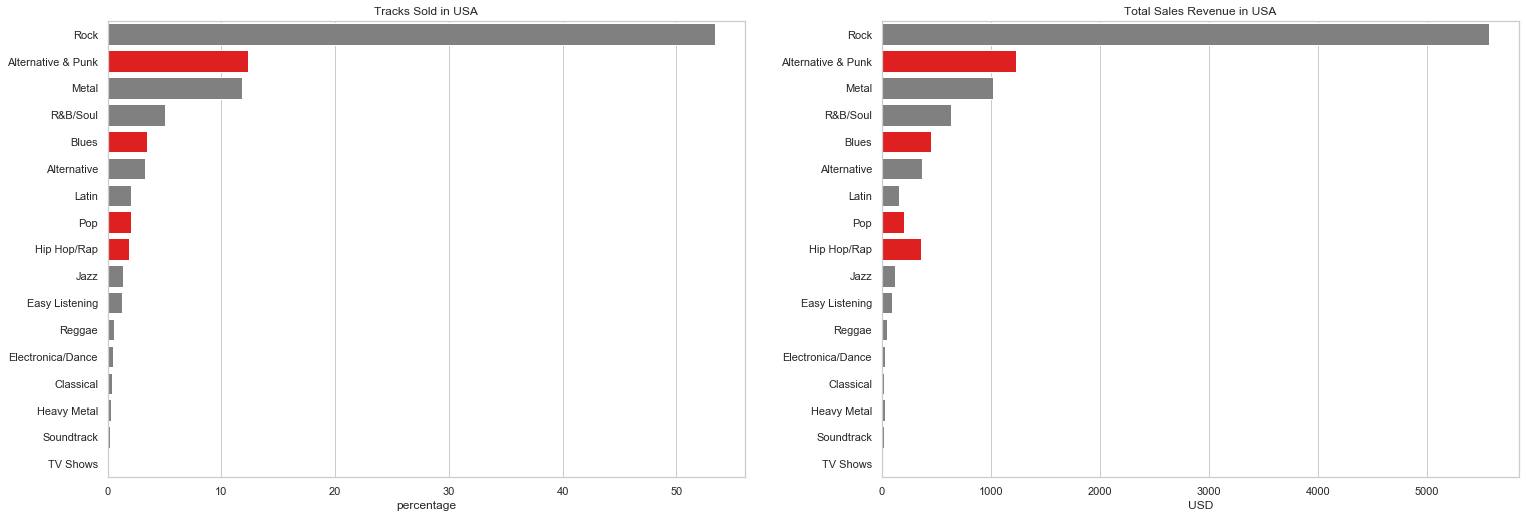

In [52]:
# Plot Genre results
sns.set(style='whitegrid')

fig, ax =plt.subplots(1,2, figsize=(22, 8))
sns.barplot(x="pct_of_total", y="genre", data=top_usa_genres, 
            palette = ['red' if x in ['Alternative & Punk','Blues','Hip Hop/Rap','Pop'] else 'grey' for x in top_usa_genres['genre']], 
            ax=ax[0])
ax[0].set(xlabel='percentage', ylabel='', title='Tracks Sold in USA')

sns.barplot(x="total_sales", y="genre", data=top_usa_genres, 
            palette = ['red' if x in ['Alternative & Punk','Blues','Hip Hop/Rap','Pop'] else 'grey' for x in top_usa_genres['genre']], 
            ax=ax[1])
ax[1].set(xlabel='USD', ylabel='', title='Total Sales Revenue in USA')

fig.tight_layout(pad=3.0)

Following our request to get the results based on number of tracks sold in the USA by genre, we see that Pop and Hip Hop/Rap are nearly tied for last. As a tie breaker, we look into actual sales revenue and see that Pop is the clear under performer, and Meteor and the Girls should be the artist that is dropped. The standout genre is Rock, so Chinook should be keen to add any Rock bands to the inventory. Going a step further let's look into Chinooks inventory based on genre relative to global sales and see if adjustments should be made.

In [77]:
%%sql genre_sales <<
/* get data on track inventory by genre */
WITH genre_inventory AS
    (
    SELECT 
        g.name,
        COUNT(*) tracks_inventory,
        1.0 * COUNT(*) / (SELECT COUNT(*) FROM track) * 100 pct_of_inventory
    FROM track t
    JOIN genre g ON t.genre_id = g.genre_id
    GROUP BY g.genre_id
    ),

/* get data on track sales by genre */
    genre_sales AS
    (
    SELECT 
        g.name,
        COUNT(*) tracks_sold,
        1.0 * COUNT(*) / (SELECT COUNT(*) FROM track) * 100 pct_tracks_sold
    FROM invoice_line il
    JOIN track t ON il.track_id = t.track_id
    JOIN genre g ON t.genre_id = g.genre_id
    GROUP BY g.genre_id
    )
    
/* Combine tables */
SELECT 
    gi.name genre,
    tracks_inventory, 
    pct_of_inventory,
    tracks_sold,
    pct_tracks_sold
FROM genre_inventory gi
JOIN genre_sales gs ON gs.name = gi.name
ORDER BY pct_tracks_sold DESC

* sqlite:///chinook.db
Done.
Returning data to local variable genre_sales


[Text(0, 0.5, ''),
 Text(0.5, 0, '%'),
 Text(0.5, 1.0, 'Percentage of Tracks Sold Relative to Inventory')]

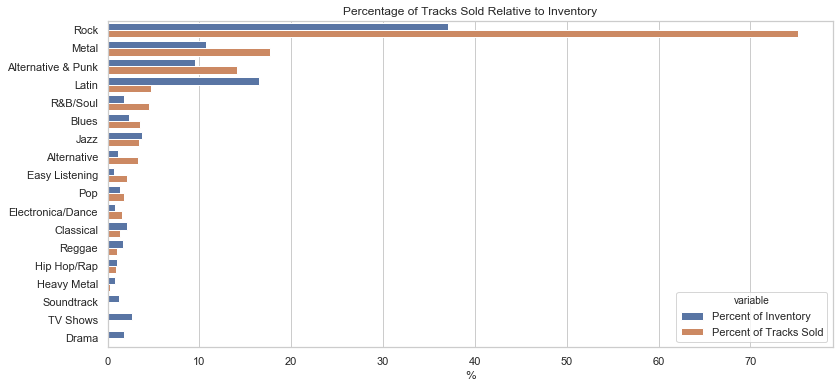

In [78]:
genre_sales = genre_sales.DataFrame()[['genre','pct_of_inventory','pct_tracks_sold']]
genre_sales.columns = ['genre','Percent of Inventory','Percent of Tracks Sold']
genre_sales = pd.melt(genre_sales, id_vars='genre', value_vars=['Percent of Inventory','Percent of Tracks Sold'])

plt.figure(figsize=(13, 6))
ax = sns.barplot(x="value", y="genre", hue="variable", data=genre_sales)
ax.set(xlabel="%", ylabel="", title="Percentage of Tracks Sold Relative to Inventory")


This chart shows which genres are selling the most tracks as well as the current distribution of inventory. It would make sense to adjust inventory to mirror the distribution of tracks sold, for example, Rock, Metal, and Alternative & Punk could use more inventory to match their high sales, while we could nearly eliminate Soundtrack, TV Shows, and Drama inventory due to lack of sales. In fact, nearly half of the inventory has never been purchased. If space is a priority, there are many tracks that can be removed.

In [107]:
%%sql tracks_purchased <<
WITH not_purchased AS
    (
    SELECT track_id
    FROM track
    EXCEPT 
    SELECT DISTINCT track_id
    FROM invoice_line
    )

SELECT 
    (COUNT(track_id) * 1.0 / (SELECT COUNT(track_id) FROM track)) * 100 AS not_purchased,
    (1 - COUNT(track_id) * 1.0 / (SELECT COUNT(track_id) FROM track)) * 100 AS purchased
FROM not_purchased

* sqlite:///chinook.db
Done.
Returning data to local variable tracks_purchased


[Text(0, 0.5, '%'),
 Text(0.5, 1.0, 'Percent of Tracks That Have Been Purchased Before')]

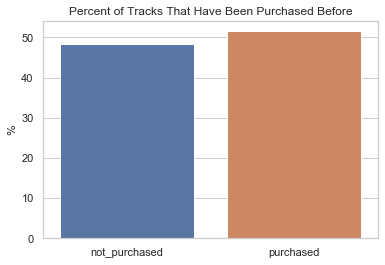

In [108]:
tracks_purchased = tracks_purchased.DataFrame()

ax = sns.barplot(x=tracks_purchased.columns, y=tracks_purchased.iloc[0])
ax.set(ylabel='%', title='Percent of Tracks That Have Been Purchased Before')

In [114]:
%%sql media_types <<
SELECT
    mt.name media_type,
    COUNT(il.invoice_id) tracks_sold
FROM invoice_line il
JOIN track t ON t.track_id = il.track_id
JOIN media_type mt ON mt.media_type_id = t.media_type_id
GROUP BY mt.name
ORDER BY tracks_sold DESC

* sqlite:///chinook.db
Done.
Returning data to local variable media_types


[Text(0, 0.5, ''),
 Text(0.5, 0, 'Number of Tracks Sold'),
 Text(0.5, 1.0, 'Number of Tracks Sold by Media Type')]

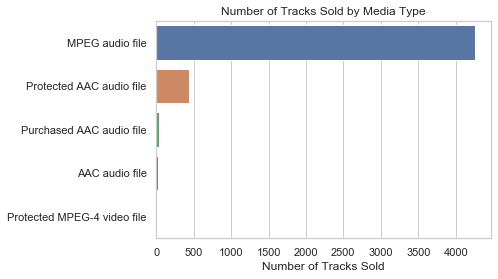

In [116]:
media_types = media_types.DataFrame()

ax=sns.barplot(x='tracks_sold', y='media_type', data=media_types)
ax.set(ylabel='', xlabel='Number of Tracks Sold', title='Number of Tracks Sold by Media Type')


As far as other inventory adjustments, Chinook should probably look to phase out non MPEG files. MPEGs account for 90% of tracks sold.

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [51]:
%%sql employee_sales <<
/* Retrive employee info, length of employment, sales per day */
SELECT 
    e.first_name || ' ' || e.last_name as employee_name,
    e.title,
    e.hire_date,
    CAST(5 AS FLOAT)/7 * (julianday('now') - julianday(e.hire_date)) as days_of_employment, /* multiplied by 5/7 to assume a 5 day work week */
    ROUND(SUM(i.total), 0) as total_sales,
    COUNT(i.invoice_id) as num_sales,
    ROUND(SUM(i.total), 0) / (CAST(5 AS FLOAT)/7 * (julianday('now') - julianday(e.hire_date))) as sales_per_day  /* total_sales / days_of_employment */
FROM employee e
LEFT JOIN customer c on e.employee_id = c.support_rep_id
LEFT JOIN invoice i on i.customer_id = c.customer_id
GROUP BY employee_id

* sqlite:///chinook.db
Done.
Returning data to local variable employee_sales


[Text(0, 0.5, 'USD'),
 Text(0.5, 0, 'Employee'),
 Text(0.5, 1.0, 'Sales per Day')]

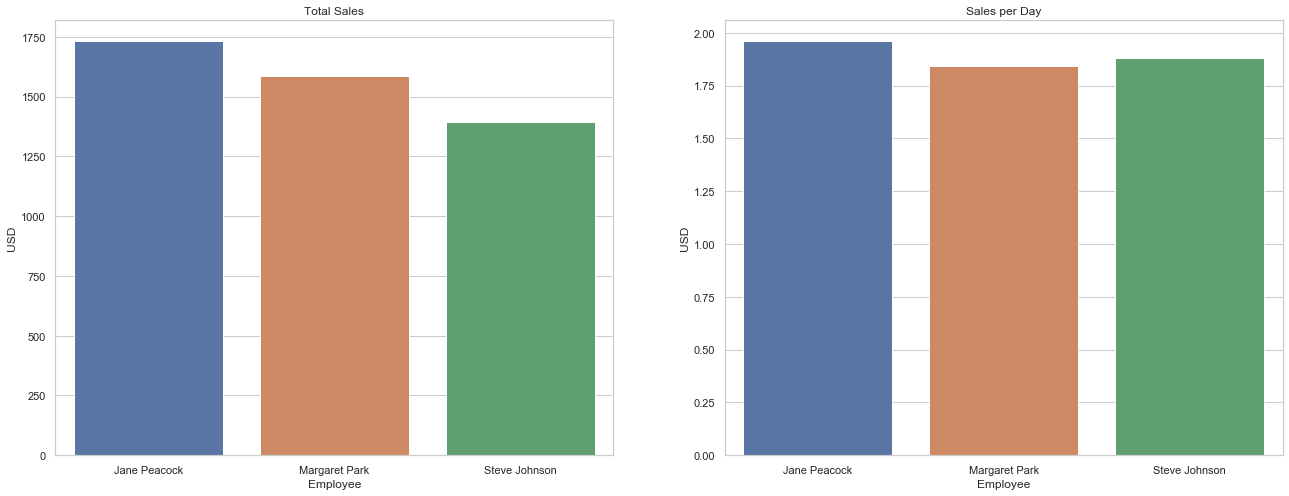

In [45]:
# Format data and plot
employee_sales = employee_sales.DataFrame()
employee_sales = employee_sales[employee_sales['title'] == 'Sales Support Agent']

fig, ax =plt.subplots(1,2, figsize=(22, 8))
sns.barplot('employee_name','total_sales', data=employee_sales, ax=ax[0])
ax[0].set(xlabel='Employee', 
          ylabel='USD',
          title='Total Sales')

sns.barplot('employee_name','sales_per_day', data=employee_sales, ax=ax[1])
ax[1].set(xlabel='Employee', 
          ylabel='USD',
          title='Sales per Day')

There are eight employees but we are just concerned with the three sales agents. Jane Peacock has the highest sales, however, since the employees have different hire dates, the relevant metric is total sales per day (we assumed a 5 day work week for all employees). Using sales per day, all three sales agents perform very similarly, at an underwhelming $1.75 to $2 per day. Either these are underperforming agents or they are working much less than a 5 day work week.

It's also been requested that we analyze sales data for customers from each country.

In [46]:
%%sql
CREATE VIEW sales_per_country AS
SELECT 
    CASE   -- Add countries with only one customer to 'Other' 
        WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 'Other'
        ELSE c.country
    END as country,
    COUNT(DISTINCT c.customer_id) num_customers,
    ROUND(SUM(i.total), 2) total_sales,
    ROUND(SUM(i.total) / COUNT(DISTINCT c.customer_id), 2) sales_per_customer,
    ROUND(SUM(i.total) / COUNT(invoice_id), 2) average_order_value
FROM customer c
JOIN invoice i on c.customer_id = i.customer_id
GROUP BY country

* sqlite:///chinook.db
(sqlite3.OperationalError) table sales_per_country already exists
[SQL: CREATE VIEW sales_per_country AS
SELECT 
    CASE   -- Add countries with only one customer to 'Other' 
        WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 'Other'
        ELSE c.country
    END as country,
    COUNT(DISTINCT c.customer_id) num_customers,
    ROUND(SUM(i.total), 2) total_sales,
    ROUND(SUM(i.total) / COUNT(DISTINCT c.customer_id), 2) sales_per_customer,
    ROUND(SUM(i.total) / COUNT(invoice_id), 2) average_order_value
FROM customer c
JOIN invoice i on c.customer_id = i.customer_id
GROUP BY country]
(Background on this error at: http://sqlalche.me/e/e3q8)


In [47]:
%%sql country_sales <<
/* Combine all 'other' countries and aggregate again */
SELECT 
    country,
    SUM(num_customers) num_customers,
    SUM(total_sales) total_sales,
    AVG(sales_per_customer) sales_per_customer,
    AVG(average_order_value) average_order_value,
    CASE 
        WHEN country = 'Other' THEN 1
        ELSE 0
    END as is_other
FROM sales_per_country
GROUP BY country
ORDER BY is_other, total_sales DESC

* sqlite:///chinook.db
Done.
Returning data to local variable country_sales


[Text(0, 0.5, ''), Text(0.5, 0, 'USD'), Text(0.5, 1.0, 'Average Order Value')]

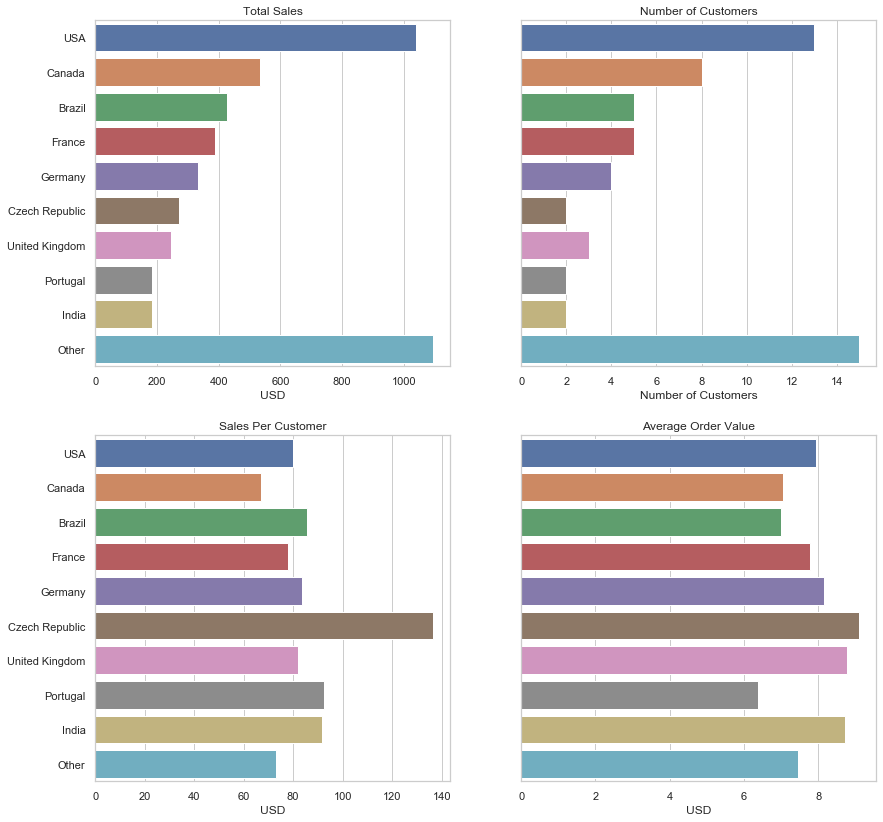

In [48]:
# Visualize data
country_sales = country_sales.DataFrame()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14), sharey=True)

sns.barplot('total_sales','country', data=country_sales, ax=ax1)
ax1.set(ylabel='', xlabel='USD', title='Total Sales')

sns.barplot('num_customers','country', data=country_sales, ax=ax2)
ax2.set(ylabel='', xlabel='Number of Customers', title='Number of Customers')

sns.barplot('sales_per_customer','country', data=country_sales, ax=ax3)
ax3.set(ylabel='', xlabel='USD', title='Sales Per Customer')

sns.barplot('diff_in_mean_order_size','country', data=country_sales, ax=ax4)
ax4.set(ylabel='', xlabel='USD', title='Aver')

The sales data shows that USA is the standout performer as far as total sales and number of customers, even though each customer doesn't buy a large amount on average. Canada is next in line. The other stand out is Czech Republic, which leads in sales per customer and average order value, however, this is based on their 2 customers, so we can't make any firm conclusions about their spending habits. At this point it would be best to try to capitalize on the USA and Canada market.

Management is considering a purchasing strategy of only purchasing the most popular single tracks from record companies, rather than purchasing entire albums. To weigh this decision, they'd like to know what percentage of customer purchases are individual tracks vs entire albums. 

In [49]:
%%sql 
/* Get a count of tracks for each album */
CREATE VIEW albums_with_count AS
SELECT 
        a.album_id,
        COUNT(t.track_id) album_track_count
    FROM album a
    JOIN track t ON t.album_id = a.album_id
    GROUP BY a.album_id


* sqlite:///chinook.db
(sqlite3.OperationalError) table albums_with_count already exists
[SQL: /* Get a count of tracks for each album */
CREATE VIEW albums_with_count AS
SELECT 
        a.album_id,
        COUNT(t.track_id) album_track_count
    FROM album a
    JOIN track t ON t.album_id = a.album_id
    GROUP BY a.album_id]
(Background on this error at: http://sqlalche.me/e/e3q8)


In [50]:
%%sql
/* Marks purchases that are full albums when the album size is more than three tracks long */
WITH full_album_purchases AS 
    (
    SELECT 
        i.invoice_id,
        t.album_id,
        CASE
            WHEN COUNT(t.track_id) = awc.album_track_count AND awc.album_track_count > 3 THEN 1
            ELSE 0
        END AS is_full_album
    FROM invoice i
    JOIN invoice_line il ON i.invoice_id = il.invoice_id
    JOIN track t ON t.track_id = il.track_id
    JOIN albums_with_count awc ON awc.album_id = t.album_id 
    GROUP BY i.invoice_id, t.album_id
    ),

/* Groups by invoice and detects if there were any full album purchases in the invoice */
full_album_purchases_per_invoice AS
    (
    SELECT
    invoice_id,
    SUM(is_full_album) contains_full_album_purchase
    FROM full_album_purchases
    GROUP BY invoice_id
    )

/* Retrieve total full album purchases and what percent of invoices contained full album purchases */
SELECT 
    SUM(contains_full_album_purchase) total_full_albums_purchased,
    AVG(contains_full_album_purchase) * 100 pct_full_albums_purchased
FROM full_album_purchases_per_invoice

* sqlite:///chinook.db
Done.


total_full_albums_purchased,pct_full_albums_purchased
110,17.91530944625407


About 18% of invoices contain a full album purchase. It would probably be unwise to drop full albums since they are still a significant source of revenue. In fact, manangement may want to consider discounting full album purchases, to encourage bigger purchases  and make use of all of the tracks that are purchased from record companies.